In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv("../csv/feedback-v2.csv")
df.columns = df.columns.str.strip()

motiv_scale = {
    "Desmotivado(a)": 1,
    "Neutro(a)": 2,
    "Motivado(a)": 3,
    "Muito motivado(a)": 4
}

motiv_cols = ["Estudo de caso", "Survey", 
              "Revisão Sistemática da Literatura (RSL)", 
              "Análise Estatística de Experimentos", 
              "Análise Qualitativa"]

contrib_scale = {
    "Discordo totalmente": 1,
    "Discordo": 2,
    "Neutro": 3,
    "Concordo": 4,
    "Concordo totalmente": 5
}

colunas = [
    'Estudo de caso',
    'Survey',
    'Revisão Sistemática da Literatura (RSL)',
    'Análise Estatística de Experimentos',
    'Análise Qualitativa',
    'Percepção Contribuição'
]

In [13]:
for col in motiv_cols:
    df[col] = df[col].map(motiv_scale)

df["Percepção Contribuição"] = df["Você acredita que a disciplina vai contribuir para sua formação?"] \
    .map(contrib_scale) \
    .fillna(3)

In [14]:
df = df[colunas]

# Verifica se há valores nulos
print(df.isna().sum())

correlacao = df.corr('spearman')

Estudo de caso                             0
Survey                                     0
Revisão Sistemática da Literatura (RSL)    0
Análise Estatística de Experimentos        0
Análise Qualitativa                        0
Percepção Contribuição                     0
dtype: int64


In [15]:
print(correlacao)

                                         Estudo de caso    Survey  \
Estudo de caso                                 1.000000  0.482504   
Survey                                         0.482504  1.000000   
Revisão Sistemática da Literatura (RSL)        0.075563  0.043284   
Análise Estatística de Experimentos            0.331418  0.138502   
Análise Qualitativa                            0.459640  0.530777   
Percepção Contribuição                         0.632785  0.467707   

                                         Revisão Sistemática da Literatura (RSL)  \
Estudo de caso                                                          0.075563   
Survey                                                                  0.043284   
Revisão Sistemática da Literatura (RSL)                                 1.000000   
Análise Estatística de Experimentos                                     0.511640   
Análise Qualitativa                                                     0.129911   
Percepção Co

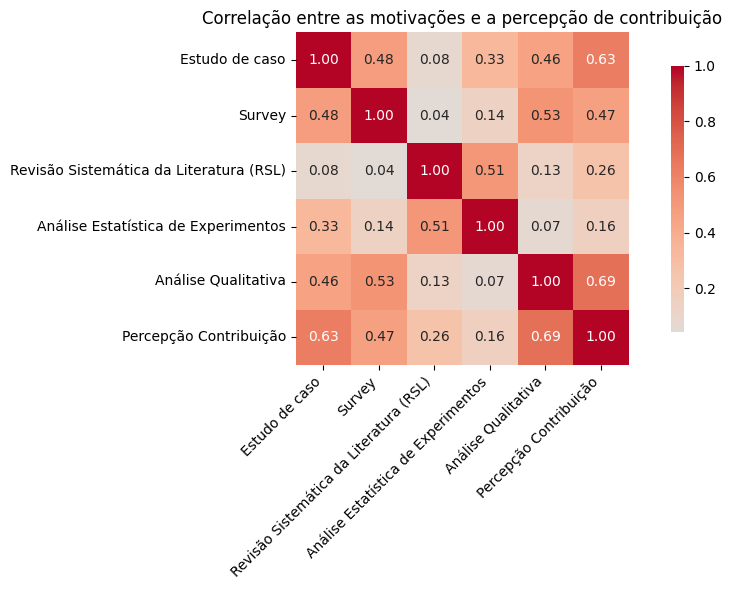

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    correlacao,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt=".2f",            # Duas casas decimais
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlação entre as motivações e a percepção de contribuição')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()